In [30]:
from pgmpy.readwrite import BIFReader
import warnings
warnings.filterwarnings("ignore")

In [2]:
reader = BIFReader("data/cancer.bif")

In [3]:
model = reader.get_model()

In [4]:
for left in model.edge:
    right = list(model.edge[left].keys())
    for r in right:
        print("{} -> {}".format(left, r))

Pollution -> Cancer
Smoker -> Cancer
Cancer -> Xray
Cancer -> Dyspnoea


In [5]:
from pgmpy.sampling import BayesianModelSampling
inference = BayesianModelSampling(model)
data = inference.forward_sample(size=100000, return_type='dataframe')

In [6]:
from profiler.core import *

In [17]:
pf = Profiler(workers=2, verbose=False, tol=0, eps=1e-6)

In [18]:
#pf.session.load_data(name='flights', src='file', fpath='/Users/zhihan/Documents/bart/data/clean_data/flights.csv', embedtxt=False)
#pf.session.load_data(name='hospital', src='file', fpath='data/hospital.csv', embedtxt=True)
pf.session.load_data(name='cancer', src='df', df=data, embedtxt=False)

INFO:profiler.utility:[0.8718771934509277] Load Data start

INFO:profiler.dataset:inferred types of attributes: {
    "Smoker": "numeric",
    "Pollution": "numeric",
    "Cancer": "numeric",
    "Xray": "numeric",
    "Dyspnoea": "numeric"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'Smoker': ['equal'], 'Pollution': ['equal'], 'Cancer': ['equal'], 'Xray': ['equal'], 'Dyspnoea': ['equal']}
INFO:profiler.dataset:(possible operators: equal, notequal, greater_than, less_than)
INFO:profiler.utility:[0.8904531002044678] Load Data execution time: 0.01857590675354004



In [19]:
s = pf.session.struct_engine
s.param['sparsity'] = 1e-6
s.n = pf.session.ds.df.shape[0]
s.param['take_abs'] = True

In [20]:
cov = s.estimate_covariance(data.values, 0, data.columns.values)

INFO:profiler.learner:use threshold 0.0201


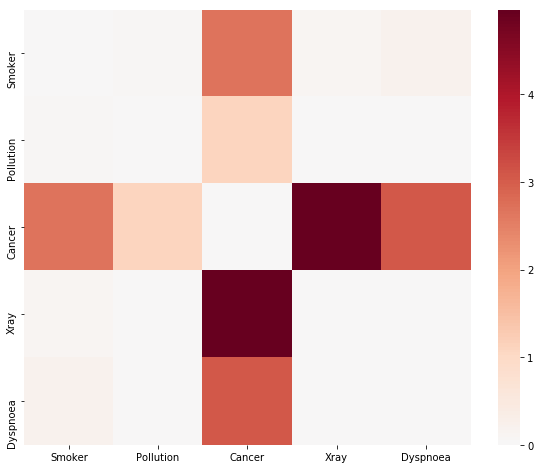

In [21]:
inv_cov, cov = s.estimate_inverse_covariance(cov.values, data.columns.values)
s.est_cov = cov

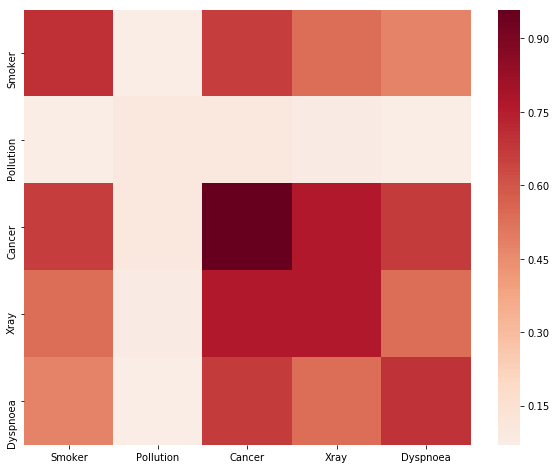

In [25]:
from profiler.utility import visualize_heatmap
visualize_heatmap(s.est_cov)

Pollution,Cancer,Xray,Dyspnoea -> Smoker
Smoker,Cancer -> Pollution
Smoker,Pollution,Xray,Dyspnoea -> Cancer
Smoker,Cancer,Dyspnoea -> Xray
Smoker,Cancer,Xray -> Dyspnoea


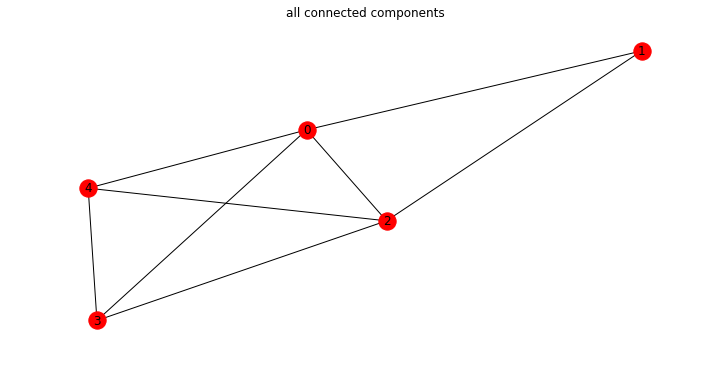

In [31]:
G = s.recover_moral_graphs(inv_cov)
G = G.get_undirected_connected_components()[0]

In [36]:
#s.recover_dag(0, G)
from profiler.utility import find_all_subsets
for i in s.idx_to_col.index.values:
    P = G.get_neighbors(i)
    attr = s.idx_to_col.loc[i, 'col']
    print("\n\n%s"%attr)
    for p in find_all_subsets(P):
        score = s.score(i, p)
        print("{} -> {} ({})".format(",".join(s.idx_to_col.loc[p, 'col']), attr, score))



Smoker
Pollution -> Smoker (0.6506124904854503)
Cancer -> Smoker (0.23654937554188288)
Xray -> Smoker (0.3254099280018218)
Dyspnoea -> Smoker (0.3659584676622439)
Pollution,Cancer -> Smoker (0.23652240271424135)
Pollution,Xray -> Smoker (0.3228854434213618)
Pollution,Dyspnoea -> Smoker (0.36088793737014685)
Cancer,Xray -> Smoker (0.2364336933081828)
Cancer,Dyspnoea -> Smoker (0.23596982834618258)
Xray,Dyspnoea -> Smoker (0.29134171053263724)
Pollution,Cancer,Xray -> Smoker (0.23640663816498414)
Pollution,Cancer,Dyspnoea -> Smoker (0.2359433340983172)
Pollution,Xray,Dyspnoea -> Smoker (0.290139256733744)
Cancer,Xray,Dyspnoea -> Smoker (0.2358595063606419)
Pollution,Cancer,Xray,Dyspnoea -> Smoker (0.23583293025253887)
 -> Smoker (0.69998)


Pollution
Smoker -> Pollution (0.09349568618807885)
Cancer -> Pollution (0.09034401037356071)
Smoker,Cancer -> Pollution (0.09033370878889296)
 -> Pollution (0.10059)


Cancer
Smoker -> Cancer (0.3238419684677146)
Pollution -> Cancer (0.860679607325

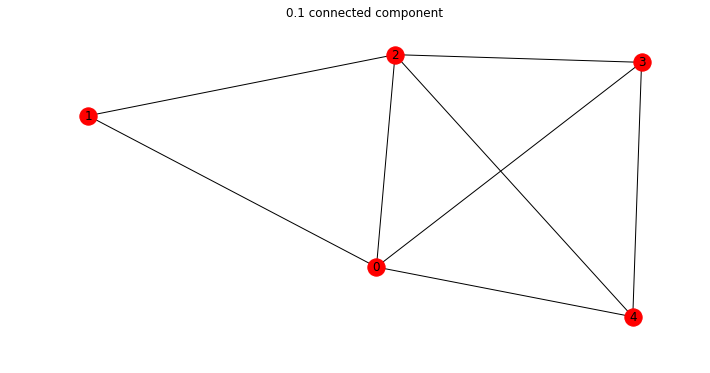

frozenset({0, 1, 2})


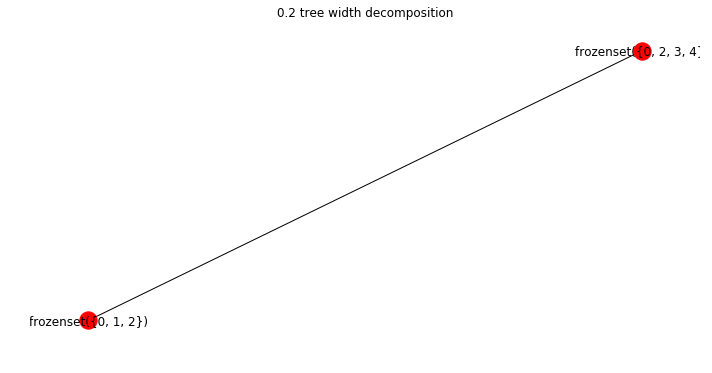

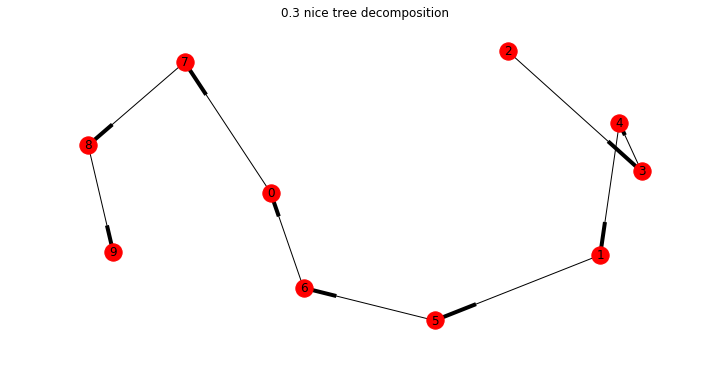

[2]forget:frozenset()
--[3]forget:frozenset({0})
----[4]forget:frozenset({0, 1})
------[1]introduce:frozenset({0, 1, 2})
--------[5]forget:frozenset({0, 2})
----------[6]forget:frozenset({0, 2, 3})
------------[0]introduce:frozenset({0, 2, 3, 4})
--------------[7]introduce:frozenset({2, 3, 4})
----------------[8]introduce:frozenset({3, 4})
------------------[9]leaf:frozenset({4})
 -> Smoker (0.69998)
Smoker, Pollution -> Cancer (0.31288979487605917)
Smoker, Cancer -> Xray (0.1574980606128753)
Smoker, Cancer, Xray -> Dyspnoea (0.21433798476896215)


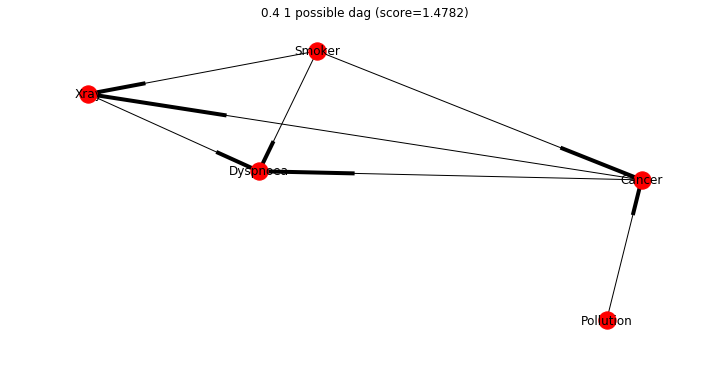

(({0: set(), 2: {0, 1}, 3: {0, 2}, 4: {0, 2, 3}},
  {0: [3, 4, 2], 2: [3, 4], 3: [4], 1: [2]},
  0,
  1934,
  162),
 1.4782015264459756)

In [35]:
s.recover_dag(0, G)